In [1]:
from pathlib import Path
import cv2
import dlib
import numpy as np
import argparse
from contextlib import contextmanager
from keras.utils.data_utils import get_file
from wide_resnet import WideResNet
from VGG_16  import VGG_16
import numpy as np
import pandas as pd
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D, Concatenate, Lambda
from keras.models import Model, Sequential
from keras import metrics
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import tensorflow as tf
import random
import keras
from keras.preprocessing import image
import matplotlib.pyplot as plt
from contextlib import contextmanager
from random_eraser import get_random_eraser
import itertools
from keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix
import os
from keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


In [2]:
def loadImage(filepath):
    test_img = image.load_img(filepath, target_size=(224, 224))
    test_img = image.img_to_array(test_img)
   
    test_img = np.expand_dims(test_img, axis = 0)

    return test_img

In [3]:
#####Initialize Models  e.g 'vgg' or 'wide resnet'
random_erase = False
test_utfk=False
test_wiki=True
model_name='vgg'
if model_name=='vgg':
    print("Model selected: VGG")
    age_model=VGG_16(101)(pretrained=True)
    age_model.load_weights('./model/age_model_weights.h5')
    gender_model=VGG_16(2)(pretrained=True)
    gender_model.load_weights('./model/gender_model_weights.h5')
    img_size=224
    print('models initialized')

elif model_name=='wide_resnet':
    print("Model selected: wide resnet")
    model= WideResNet(64, depth=16, k=8)()
    model.load_weights('./model/weights.28-3.73.hdf5')
    img_size=64
    print('models initialized')

Model selected: VGG

models initialized


In [4]:
test_size=9000

if test_utfk:
    print("Executing test on utfk data")
    path = "./dataset/crop_part1/"
    files = os.listdir(path)
    size = len(files)
#     test_size=1000
    import cv2
    images = []
    ages = []
    genders = []
    for i, file in tqdm(enumerate(files)):
        if i == test_size:
            break
        
        split_var = file.split('_')
        if(int(split_var[1])==3):
            print("Invalid value 3. Skipping this iteration")
            continue
        image = cv2.imread(path+file)
  
        image = cv2.resize(image,dsize=(img_size,img_size))
        image = image.reshape((image.shape[0],image.shape[1],3))
        images.append(image)
        
        ages.append(split_var[0])
        genders.append(int(split_var[1]) )
            
    import numpy as np
    test_x=np.array(images)
    test_y=ages
    genders = keras.utils.to_categorical(genders, 2)
elif test_wiki:
    print("Executing test on wiki data")
    features=torch.load('./dataset/features.pt').numpy()
    target=torch.load('./dataset/age.pt').numpy()
    gender=torch.load('./dataset/gender.pt').numpy()
    test_idx=random.choices(np.arange(features.shape[0]),k=test_size)
    test_x=features[test_idx,...]
    test_y=target[test_idx,...]
    genders=gender[test_idx,...]
    genders = keras.utils.to_categorical(genders, 2)
    del features
    del target 
    del gender
    if img_size==64:
        test_x=np.concatenate([cv2.resize(img, (64,64))[None,:,:,:] for img in tqdm(test_x)], axis=0)
        
if random_erase == True:
    print("Adding noise to test data")
    datagen = ImageDataGenerator(
                    horizontal_flip=0.3,
                    rotation_range=60,
                    featurewise_center=False,
                    samplewise_center=False,
                    featurewise_std_normalization=False,
                    samplewise_std_normalization=False,
                    zca_whitening=False,
                    zca_epsilon=1e-06,
                    width_shift_range=0.3,
                    height_shift_range=0.3,
                    brightness_range=None,
                    shear_range=0.1,
                    zoom_range=0.2,
                    channel_shift_range=0.0,
                    fill_mode="nearest",
                    cval=0.0,
                    vertical_flip=True,
                    rescale=None,
                    preprocessing_function=None,
                    data_format=None,
                    validation_split=0.0,
                    dtype=None
                )
#             preprocessing_function=get_random_eraser(v_l=0, v_h=255))
    datagen.fit(test_x)
    
    for img in tqdm(datagen.flow(test_x, batch_size=test_size)):
#         plt.imshow(cv2.cvtColor(img.squeeze(0), cv2.COLOR_BGR2RGB).astype('uint8'))
        test_x = img
        break


Executing test on wiki data
Adding noise to test data


  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
if model_name=='vgg':
    print("Normalizing test data")
    test_x=test_x/255
    predictions = age_model.predict(test_x)
    gender_predictions = gender_model.predict(test_x)
    
elif  model_name=='wide_resnet':
    predictions=model.predict(test_x)
    gender_predictions=predictions[0]
    predictions=predictions[1]

Normalizing test data



In [6]:
output_indexes = np.array([i for i in range(0, 101)])
apparent_predictions = np.sum(predictions * output_indexes, axis = 1)

In [7]:
mae = 0
actual_mean = 0

for i in range(0 ,apparent_predictions.shape[0]):
    prediction = int(apparent_predictions[i])
    actual = round(int(test_y[i]))
    
    abs_error = abs(prediction - actual)
    actual_mean = actual_mean + actual
    
    mae = mae + abs_error
    
mae = mae / apparent_predictions.shape[0]

print("mae: ",mae)
print("instances: ",apparent_predictions.shape[0])

mae:  14.253444444444444
instances:  9000


## Gender Accuracy

In [8]:
pred_list = []; actual_list = []

for i in gender_predictions:
    if(test_utfk==True):
        pred_list.append(np.argmin(i))
    else:
        pred_list.append(np.argmax(i))

for i in genders: 
    actual_list.append(np.argmax(i))

cmt=confusion_matrix(actual_list, pred_list)
print(classification_report(actual_list, pred_list))

              precision    recall  f1-score   support

           0       0.28      0.10      0.15      2642
           1       0.70      0.89      0.79      6358

    accuracy                           0.66      9000
   macro avg       0.49      0.50      0.47      9000
weighted avg       0.58      0.66      0.60      9000



Normalized confusion matrix


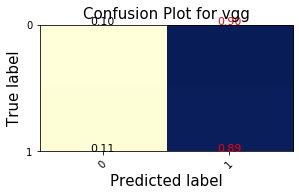

In [9]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap='YlGnBu')
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="red" if cm[i, j] > thresh else "black", fontsize = 11)

    plt.tight_layout()
    plt.ylabel('True label', fontsize = 15)
    plt.xlabel('Predicted label', fontsize = 15)
    
plt.figure(figsize=(4,4))
plot_confusion_matrix(cmt, classes=np.arange(2),normalize=True)
plt.title('Confusion Plot for '+ model_name, fontsize='15')
plt.savefig('confusion_matrix.png')

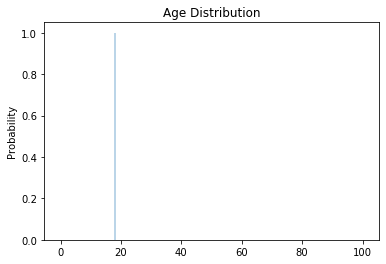

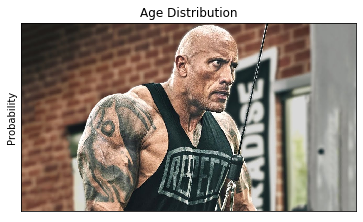

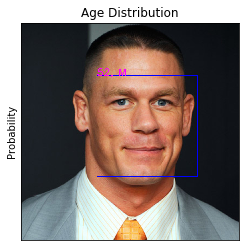

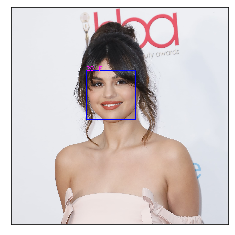

In [13]:
y_pos = np.arange(101)
detector = dlib.get_frontal_face_detector()

margin=0.4

video=False
image_dir='./dataset/test_images/'

@contextmanager

def video_capture(*args, **kwargs):
    cap = cv2.VideoCapture(*args, **kwargs)
    try:
        yield cap
    finally:
        cap.release()

def yield_images():

    with video_capture(0) as cap:
        cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
        cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
        while True:
            ret, img = cap.read()
            if not ret:

                raise RuntimeError("Failed to capture image")
            yield img


def draw_label(image, point, label, font=cv2.FONT_HERSHEY_SIMPLEX, font_scale=1.8, thickness=1):


    size = cv2.getTextSize(label, font, font_scale, thickness)[0]

    x, y = point

    cv2.putText(image, label, point, font, font_scale, (255, 0, 255), 3)



def yield_images_from_dir(image_dir):

    image_dir = Path(image_dir)



    for image_path in image_dir.glob("*.jpg*"):
      
        img = cv2.imread(str(image_path), 1)
        yield img


image_generator =  yield_images() if video  else   yield_images_from_dir(image_dir)
k=0

for k, image in enumerate(image_generator) :
       
     
        img=cv2.resize(image, (img_size,img_size))
        input_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        img_h, img_w, _ = np.shape(input_img)
        ih, iw, _ = np.shape(image)

        detected = detector(image, 1)
        faces = np.empty((len(detected), img_size, img_size, 3))
        for i, d in enumerate(detected):
                    d=detected[i]
                    x1, y1, x2, y2, w, h = d.left(), d.top(), d.right() + 1, d.bottom() + 1, d.width(), d.height()

                    xw1 = max(int(x1 - margin * w), 0)

                    yw1 = max(int(y1 - margin * h), 0)

                    xw2 = min(int(x2 + margin * w), iw - 1)

                    yw2 = min(int(y2 + margin * h), ih - 1)

                    cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 4)
         
                    faces[i, :, :, :] = cv2.resize(image[yw1:yw2 + 1, xw1:xw2 + 1, :], (img_size, img_size))
                    if model_name=='vgg':
                    
                        results_age = age_model.predict(np.expand_dims(faces[i,:,:,:],axis=0))
                        predicted_genders=gender_model.predict(np.expand_dims(faces[i,:,:,:],axis=0))
                    elif model_name=='wide_resnet':
                        results=model.predict(np.expand_dims(faces[i,:,:,:],axis=0))
                        results_age=results[1]
                        predicted_genders=results[0]
                        

                    plt.bar(y_pos, results_age[0], align='center', alpha=0.3)
                    plt.ylabel('Probability')
                    plt.title('Age Distribution')
                    plt.show()
                    ages = np.arange(0, 101).reshape(101, 1)
                    predicted_ages = results_age[0].dot(ages).flatten()
                    
                    label = "{}, {}".format(int(predicted_ages),"M" if np.argmax(predicted_genders)==1 else "F")

                    draw_label(image, (d.left(), d.top()), label)

        
        
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.xticks([])
        plt.yticks([])
